In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from IPython.display import clear_output
from matplotlib.pyplot import imshow
import pandas as pd
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *
from tensorflow.keras.metrics import *
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import backend as k
from tqdm.auto import tqdm

## Reading data

In [2]:
train_df = pd.read_csv('./data/train.csv')
train_df.head()

,id,path,label
0,TRAIN_000,./train/TRAIN_000.mp4,3
1,TRAIN_001,./train/TRAIN_001.mp4,0
2,TRAIN_002,./train/TRAIN_002.mp4,1
3,TRAIN_003,./train/TRAIN_003.mp4,4
4,TRAIN_004,./train/TRAIN_004.mp4,4


In [3]:
len(train_df)

610

In [4]:
content = []
y = []

for i in tqdm(range(len(train_df))):
    file = train_df.loc[i, 'id']
    fname = f'{file}.mp4'
    label = train_df.loc[i, 'label']
    content.append(fname)
    y.append(label)

  0%|          | 0/610 [00:00<?, ?it/s]

In [5]:
content = np.array(content)
y = np.array(y)

In [6]:
content.shape, y.shape

((610,), (610,))

In [7]:
def read_frames(root_folder, arr, each_nth=10):
    videos=[]
    for j  in range(len(arr)):
        clear_output()
        print(np.round(100*j/len(arr),3))
            
        vcap=cv2.VideoCapture(root_folder+arr[j])
        success=True
  
        frames=[]
        cnt=0
        while success:
            try:
              success,image=vcap.read()
              cnt+=1
              if cnt%each_nth==0:
                image=resize(image,(128,128))
                frames.append(image)
            except Exception as e:
                print(e)
        videos.append(frames)
    
    return videos

In [8]:
def select_frames(frames_arr , n=10):
    videos=[]
    for i in range(len(frames_arr)):
        frames=[]
        for t in np.linspace(0, len(frames_arr[i])-1, num=n):
            frames.append(frames_arr[i][int(t)])
        videos.append(frames)
        
    videos = np.array(videos)
    print(videos.shape)
    return videos

In [9]:
X_frames = read_frames('./data/train/', content)
X_frames = select_frames(X_frames, 30)

99.836


[ WARN:0@21.527] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@21.527] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin609 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@21.527] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@21.527] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_16

(610, 30, 128, 128, 3)


In [10]:
xtr, xte, ytr, yte = train_test_split(X_frames, y, shuffle=True, test_size=0.2, random_state=42)

In [11]:
ytr = to_categorical(ytr, 5)
yte = to_categorical(yte, 5)

In [12]:
xtr.shape, xte.shape, ytr.shape, yte.shape

((488, 30, 128, 128, 3), (122, 30, 128, 128, 3), (488, 5), (122, 5))

In [13]:
ytr[0]

array([0., 0., 1., 0., 0.], dtype=float32)

## Random Sample Visualization

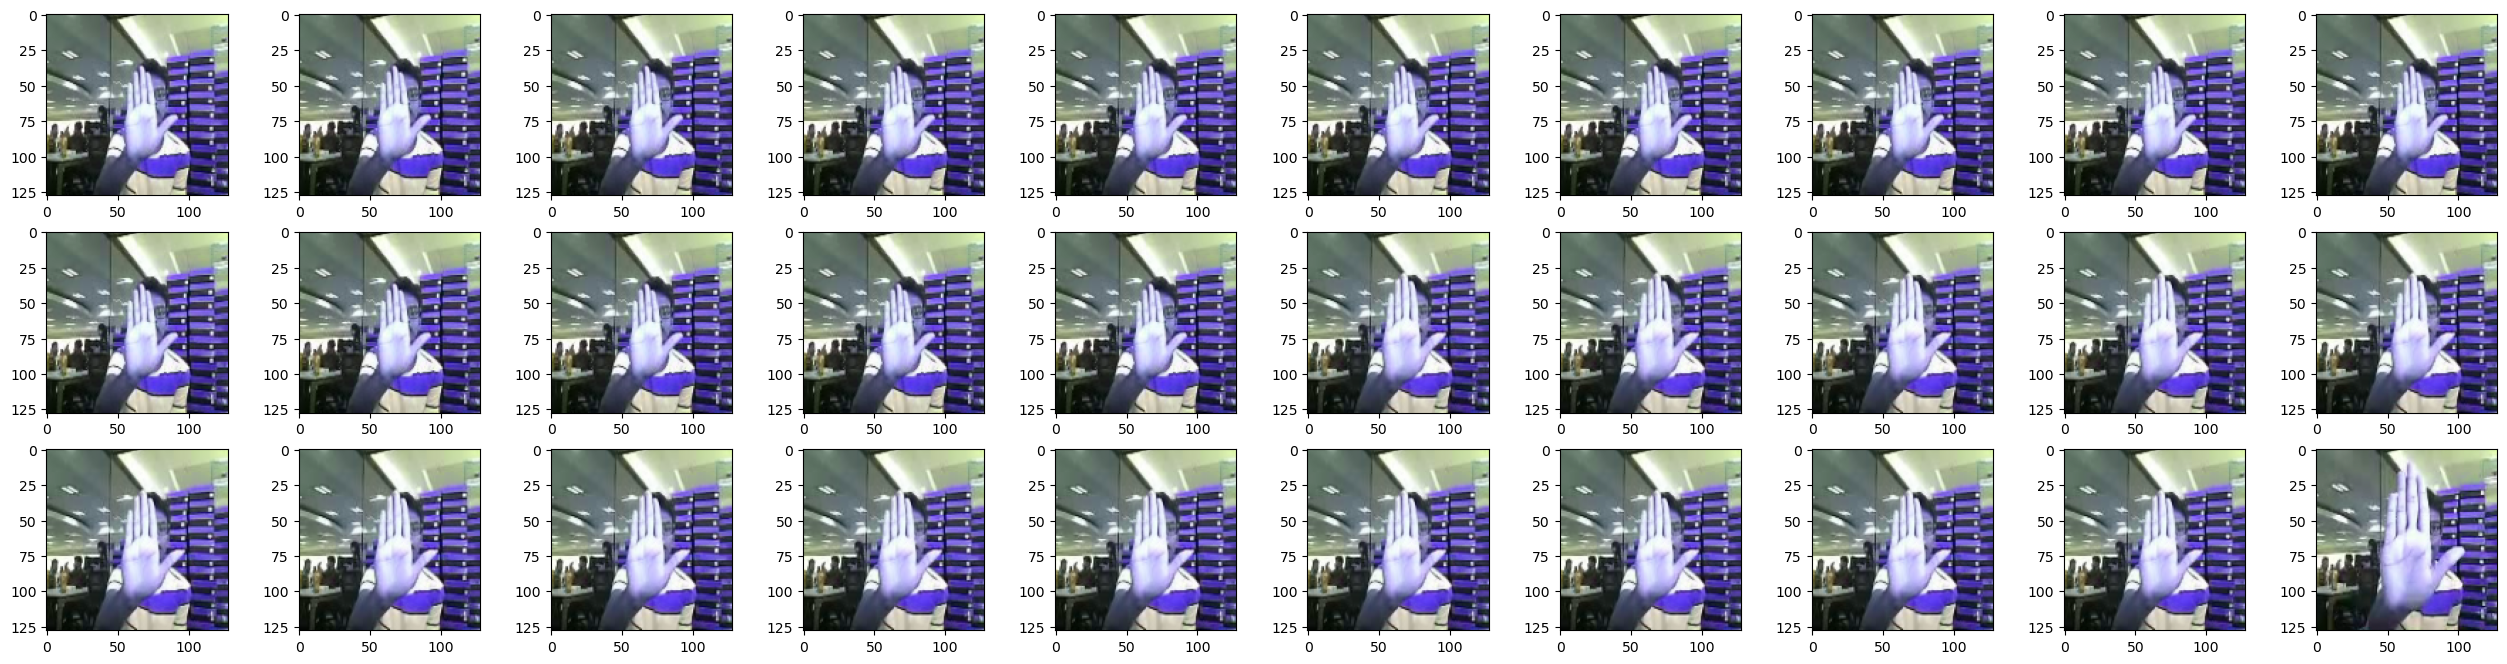

In [14]:
flg = plt.figure(figsize=(32, 8))
random_video_index = np.random.randint(0, len(X_frames))

for i, image in enumerate(X_frames[random_video_index]):
    ax = plt.subplot(3, 10, i+1)
    imshow(image)

## Building model

In [15]:
def list_to_stack(xs):
    xs = tf.stack(xs, axis = 1)
    s = tf.shape(xs)

    return xs

In [32]:
ish=(30, 128, 128, 3)
  
xs=[]


inp = Input(ish)

for slice_indx in range(0,10,1):
  x=Lambda(lambda x: x[:, slice_indx])(inp)
  x=BatchNormalization(momentum=0.8)(x)
  x=Conv2D(filters=20, kernel_size=3, padding='same', activation='relu')(x)
  x=BatchNormalization(momentum=0.8)(x)
  x=MaxPooling2D(pool_size=2)(x)
  
  x=Conv2D(filters=30, kernel_size=3, padding='same', activation='relu')(x)
  x=BatchNormalization(momentum=0.8)(x)
  x=MaxPooling2D(pool_size=2)(x)
  x=Conv2D(filters=30, kernel_size=3, padding='same', activation='relu')(x)
    
  xs.append(x)
  

t=Lambda(list_to_stack)(xs)
t=Conv3D(50,3,padding='same')(t)
# t=BatchNormalization(momentum=0.8)(t) # 왜 에러나지?
target_shape=(10,32*32*50)
t=Reshape(target_shape)(t)
t=GRU(25, return_sequences=True)(t)
t=GRU(50, return_sequences=False,dropout=0.5)(t)

t=Dense(100,'relu')(t)
out=Dense(5, activation='softmax')(t)

model = Model(inputs=inp, outputs=out)
opt = tf.keras.optimizers.SGD(lr=0.0087)
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy'])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 30, 128, 12  0           []                               
                                8, 3)]                                                            
                                                                                                  
 lambda_55 (Lambda)             (None, 128, 128, 3)  0           ['input_6[0][0]']                
                                                                                                  
 lambda_56 (Lambda)             (None, 128, 128, 3)  0           ['input_6[0][0]']                
                                                                                                  
 lambda_57 (Lambda)             (None, 128, 128, 3)  0           ['input_6[0][0]']          

## model design

In [33]:
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

## Training model

In [34]:
history = model.fit(xtr, ytr, epochs=10, batch_size=10,validation_data=(xte, yte),shuffle  = True)

Epoch 1/10


2023-01-25 20:29:21.424861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-25 20:29:22.354920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-25 20:29:22.557981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-25 20:29:23.047109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-25 20:29:23.484136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


49/49 [==============================] - ETA: 0s - loss: 1.6010 - accuracy: 0.2336

2023-01-25 20:29:46.949852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-25 20:29:47.554400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-25 20:29:47.631820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


49/49 [==============================] - 30s 516ms/step - loss: 1.6010 - accuracy: 0.2336 - val_loss: 1.5004 - val_accuracy: 0.4016
Epoch 2/10
49/49 [==============================] - 17s 350ms/step - loss: 1.4360 - accuracy: 0.4426 - val_loss: 1.3066 - val_accuracy: 0.5574
Epoch 3/10
49/49 [==============================] - 18s 358ms/step - loss: 1.2587 - accuracy: 0.5758 - val_loss: 1.1899 - val_accuracy: 0.6557
Epoch 4/10
49/49 [==============================] - 17s 343ms/step - loss: 1.0654 - accuracy: 0.6967 - val_loss: 1.0708 - val_accuracy: 0.6557
Epoch 5/10
49/49 [==============================] - 17s 347ms/step - loss: 0.8835 - accuracy: 0.8053 - val_loss: 1.0200 - val_accuracy: 0.6393
Epoch 6/10
49/49 [==============================] - 16s 332ms/step - loss: 0.6838 - accuracy: 0.8730 - val_loss: 0.9164 - val_accuracy: 0.6885
Epoch 7/10
49/49 [==============================] - 16s 330ms/step - loss: 0.4713 - accuracy: 0.9467 - val_loss: 0.8691 - val_accuracy: 0.6721
Epoch 8/10